# Spectral Clustering on Non-Convex Data
 Presented by: Yosser Fhal
 
 This notebook demonstrates Spectral Clustering for grouping non-convex data (e.g., circular or complex shapes).

 It follows the concepts from the provided presentation, with visualizations to help you learn.

# Why Spectral Clustering?
 - Traditional clustering (e.g., K-Means) assumes spherical (convex) clusters and uses distance.
 - Spectral Clustering uses graph connectivity (relationships) via eigenvalues/eigenvectors, making it ideal for non-convex shapes like circles or moons.
- Example: In social networks, people in the same community might not be directly close but connected via friends.

# Spectral Clustering on Sine and Circle Datasets
* This notebook demonstrates manual implementation of Spectral Clustering (without using sklearn's SpectralClustering)
* to explain the algorithm step-by-step. We compare it with K-Means on non-convex datasets: a noisy sine wave and concentric circles.
* Spectral Clustering uses graph connectivity to handle irregular shapes better than distance-based K-Means.
* For the circle dataset, we use the provided code to generate the dataset (two outer circles and two inner circles, labeled 0,1,2).
* The raw dataset plot is shown in all red (no color differentiation by labels).

*1. Import necessary libraries*


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly
import plotly.graph_objs as go
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import pdist, squareform
import warnings
import time
from sklearn.metrics import silhouette_score
warnings.filterwarnings('ignore')

# Manual Spectral Clustering Function
This function implements Spectral Clustering manually:
1. Build affinity matrix using either k-nearest neighbors or rbf.
2. Compute degree matrix and Laplacian.
3. Find eigenvectors of Laplacian.
4. Cluster the eigenvectors using K-Means.


In [ ]:
def manual_spectral_clustering(X, n_clusters=2, affinity='nearest_neighbors', n_neighbors=15, gamma=1.0, random_state=42):
    # Step 1: Affinity matrix A
    if affinity == 'nearest_neighbors':
        # Build affinity matrix (k-nearest neighbors(k-NN Graph))
        A = kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity', include_self=False) #returns a sparse matrix where A[i,j] = 1 if j is among i's k nearest neighbors (connectivity mode).
        A = A.toarray() #converts to dense numpy array (could be memory heavy if many samples).
        A = (A + A.T) / 2  #make the matrix symmetrical, so if A connects to B, B connects to A.
    elif affinity == 'rbf':
        #Fully-connected graph
        # Build affinity matrix using RBF (Gaussian) Similarity
        #Compute pairwise Euclidean distances between rows of X.
        #RBF (Gaussian) similarity: A[i,j] = exp(-gamma * ||x_i - x_j||^2). Larger gamma → more rapid decay with distance (local affinities).
        pairwise_dists = squareform(pdist(X, 'euclidean'))
        A = np.exp(-gamma * pairwise_dists ** 2)
    else:
        raise ValueError("Affinity must be 'nearest_neighbors' or 'rbf'") #Input validation.
    
    # Step 2: Degree matrix D
    D = np.diag(np.sum(A, axis=1))
    
    # Step 3: Laplacian L = D - A
    #It tells us how points are connected and where the “gaps” or cluster boundaries are.
    L = D - A
    
    # Step 4: Compute eigenvectors (smallest eigenvalues first)
    eigenvalues, eigenvectors = eigsh(L, k=n_clusters+1, which='SM')
    eigenvectors = eigenvectors[:, 1:n_clusters+1]  # Skip the first
    
    # Step 5: Normalize rows of eigenvectors
    #This prevents large values from dominating and prepares the data for K-Means.
    eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=1, keepdims=True)
    
    # Step 6: Cluster using K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=random_state)
    labels = kmeans.fit_predict(eigenvectors)
    
    return labels

# Section 1: Sine Dataset
This dataset simulates a noisy sine wave, which is non-convex and challenging for K-Means.

Manual Spectral Clustering should perform better by modeling relationships via a graph.


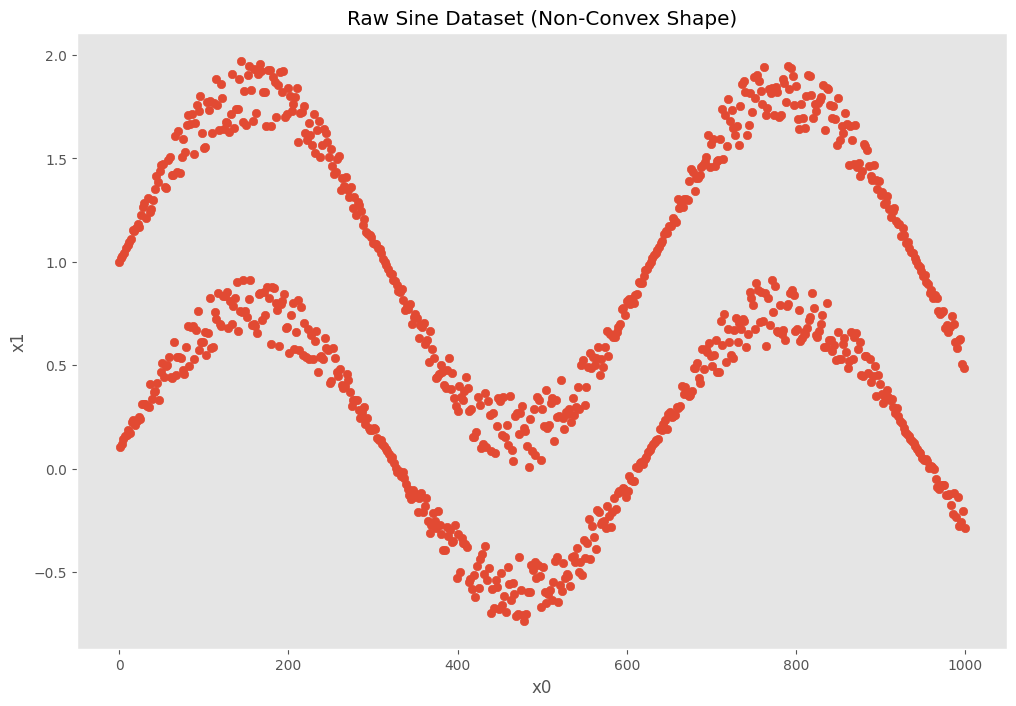

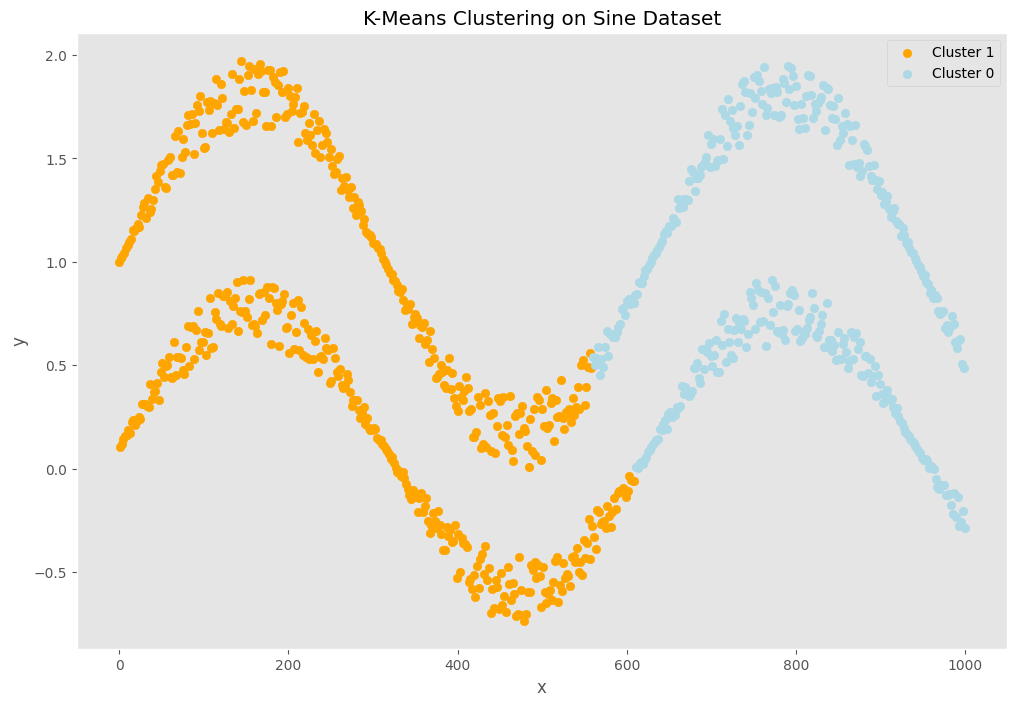

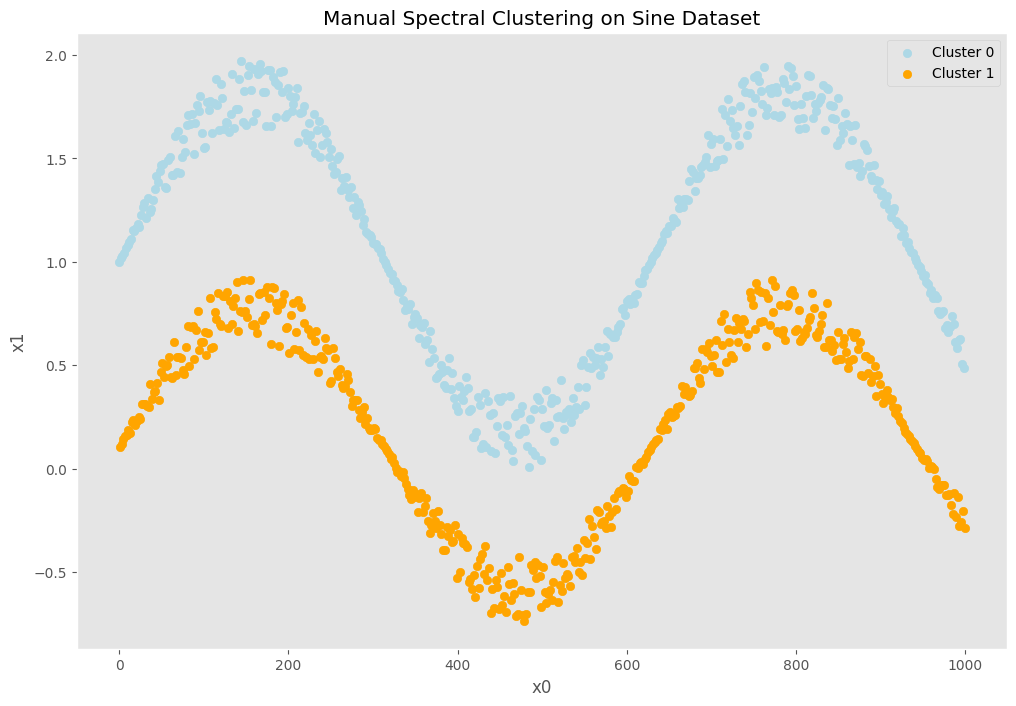

Silhouette Score - K-Means: 0.416
Silhouette Score - Manual Spectral: 0.183


In [ ]:
# Generate the sine dataset
nb_samples = 1000
X = np.zeros(shape=(nb_samples, 2))
sine_dataset = pd.DataFrame(X)

for i in range(nb_samples):
    X[i, 0] = float(i)
    if i % 2 == 0:
        X[i, 1] = 1.0 + (np.random.uniform(0.65, 1.0)) * np.sin(float(i) / 100.0)
    else:
        X[i, 1] = 0.1 + (np.random.uniform(0.5, 0.85)) * np.sin(float(i) / 100.0)

# Visualize the raw sine data
fig = plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Raw Sine Dataset (Non-Convex Shape)')
plt.grid()
plt.show()

# Standardize the data
#values in the dataset are being scaled between 0 and 1
scaler = MinMaxScaler().fit(X) 
X_scaled = scaler.transform(X)
#Prevents one feature from dominating because it has bigger values

# Fit K-Means with 2 clusters
kmeans_md = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42).fit(X_scaled)

# Append cluster labels
sine_dataset.columns = ['x', 'y']
sine_dataset['kmeans_cluster'] = kmeans_md.labels_

# Visualize K-Means results
colors = ['lightblue', 'orange']
fig = plt.figure(figsize=(12, 8))
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering on Sine Dataset')
plt.grid()

for c in sine_dataset['kmeans_cluster'].unique():
    temp = sine_dataset[sine_dataset['kmeans_cluster'] == c]
    plt.scatter(temp['x'], temp['y'], color=colors[c], label=f'Cluster {c}')
plt.legend()
plt.show()

# Manual Spectral Clustering with 2 clusters (nearest_neighbors)
spectral_labels = manual_spectral_clustering(X_scaled, n_clusters=2, affinity='nearest_neighbors', n_neighbors=15, random_state=42)
sine_dataset['spectral_clusters'] = spectral_labels

# Visualize Manual Spectral Clustering results
fig = plt.figure(figsize=(12, 8))
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Manual Spectral Clustering on Sine Dataset')
plt.grid()

for c in sine_dataset['spectral_clusters'].unique():
    temp = sine_dataset[sine_dataset['spectral_clusters'] == c]
    plt.scatter(temp['x'], temp['y'], color=colors[c], label=f'Cluster {c}')
plt.legend()
plt.show()

# Evaluate and Compare Clusters
sil_kmeans = silhouette_score(X_scaled, kmeans_md.labels_)
sil_spectral = silhouette_score(X_scaled, spectral_labels)
print(f"Silhouette Score - K-Means: {sil_kmeans:.3f}")
print(f"Silhouette Score - Manual Spectral: {sil_spectral:.3f}")

# Interactive Plotly Visualization for Sine Dataset
traces = []
for c in sine_dataset['spectral_clusters'].unique():
    temp = sine_dataset[sine_dataset['spectral_clusters'] == c]
    trace = go.Scatter(x=temp['x'], y=temp['y'], mode='markers', 
                       marker=dict(color=colors[c], size=8), 
                       name=f'Cluster {c}')
    traces.append(trace)

layout = go.Layout(title='Interactive Manual Spectral Clustering on Sine Dataset',
                   xaxis=dict(title='x'),
                   yaxis=dict(title='y'),
                   showlegend=True)
fig = go.Figure(data=traces, layout=layout)
plotly.offline.iplot(fig)

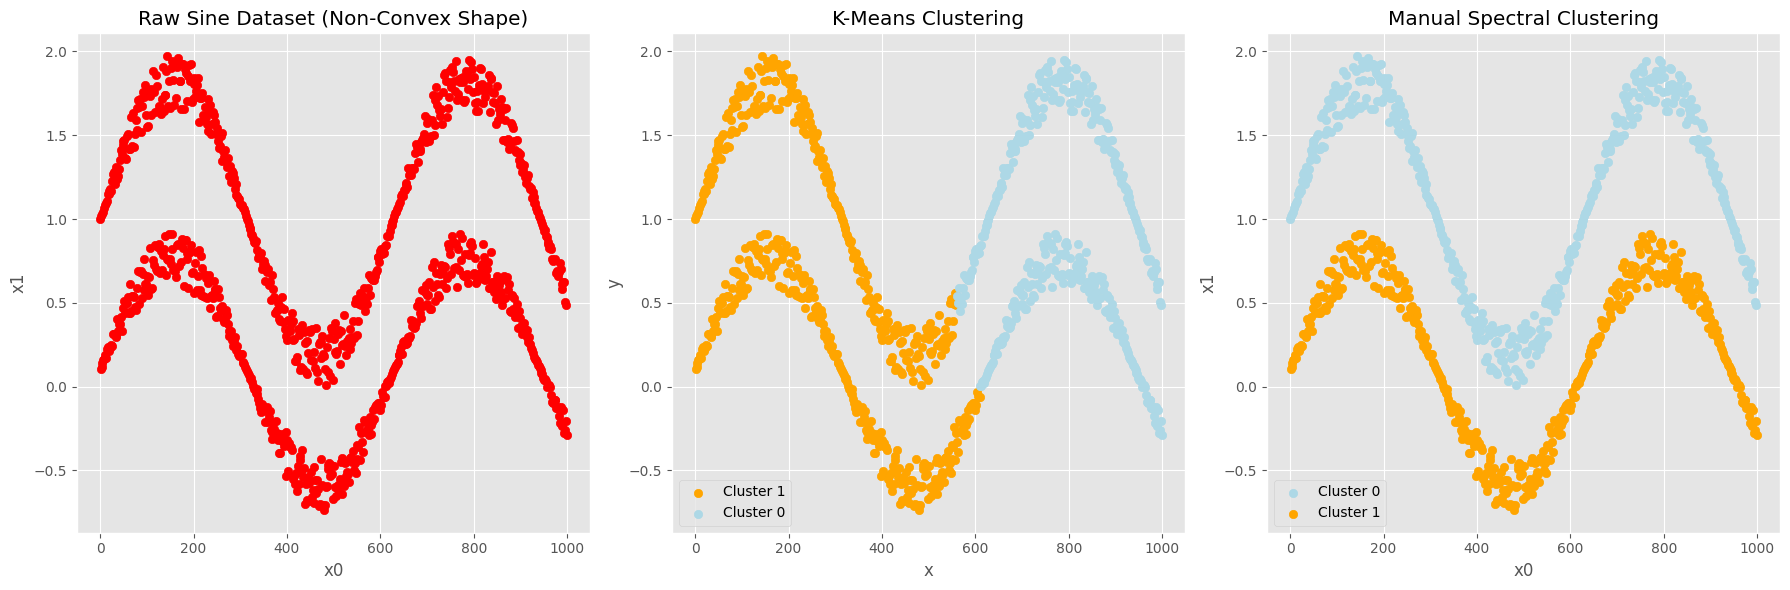

In [19]:
# Create a 1x3 subplot layout for all three plots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- 1. Raw Sine Data ---
axes[0].scatter(X[:, 0], X[:, 1], color='red')
axes[0].set_xlabel('x0')
axes[0].set_ylabel('x1')
axes[0].set_title('Raw Sine Dataset (Non-Convex Shape)')
axes[0].grid(True)

# --- 2. K-Means Clustering ---
for c in sine_dataset['kmeans_cluster'].unique():
    temp = sine_dataset[sine_dataset['kmeans_cluster'] == c]
    axes[1].scatter(temp['x'], temp['y'], color=colors[c], label=f'Cluster {c}')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('K-Means Clustering')
axes[1].legend()
axes[1].grid(True)

# --- 3. Manual Spectral Clustering ---
for c in sine_dataset['spectral_clusters'].unique():
    temp = sine_dataset[sine_dataset['spectral_clusters'] == c]
    axes[2].scatter(temp['x'], temp['y'], color=colors[c], label=f'Cluster {c}')
axes[2].set_xlabel('x0')
axes[2].set_ylabel('x1')
axes[2].set_title('Manual Spectral Clustering')
axes[2].legend()
axes[2].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [25]:

# --- K-Means Timing & Scoring ---
start_kmeans = time.time()
kmeans_md = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42).fit(X_scaled)
end_kmeans = time.time()
kmeans_time = end_kmeans - start_kmeans
sil_kmeans = silhouette_score(X_scaled, kmeans_md.labels_)

# --- Manual Spectral Clustering Timing & Scoring ---
start_spectral = time.time()
spectral_labels = manual_spectral_clustering(
    X_scaled, n_clusters=2, affinity='nearest_neighbors',
    n_neighbors=15, random_state=42
)
end_spectral = time.time()
spectral_time = end_spectral - start_spectral
sil_spectral = silhouette_score(X_scaled, spectral_labels)

# --- Display Results ---
print("=== Clustering Performance Summary ===")
print(f"K-Means:\n  Time Taken       : {kmeans_time:.4f} seconds")
#print(f"  Silhouette Score : {sil_kmeans:.3f}\n")

print(f"Manual Spectral Clustering:\n  Time Taken       : {spectral_time:.4f} seconds")
#print(f"  Silhouette Score : {sil_spectral:.3f}")


=== Clustering Performance Summary ===
K-Means:
  Time Taken       : 0.0979 seconds
Manual Spectral Clustering:
  Time Taken       : 2.1114 seconds


# Section 2: Circle Dataset


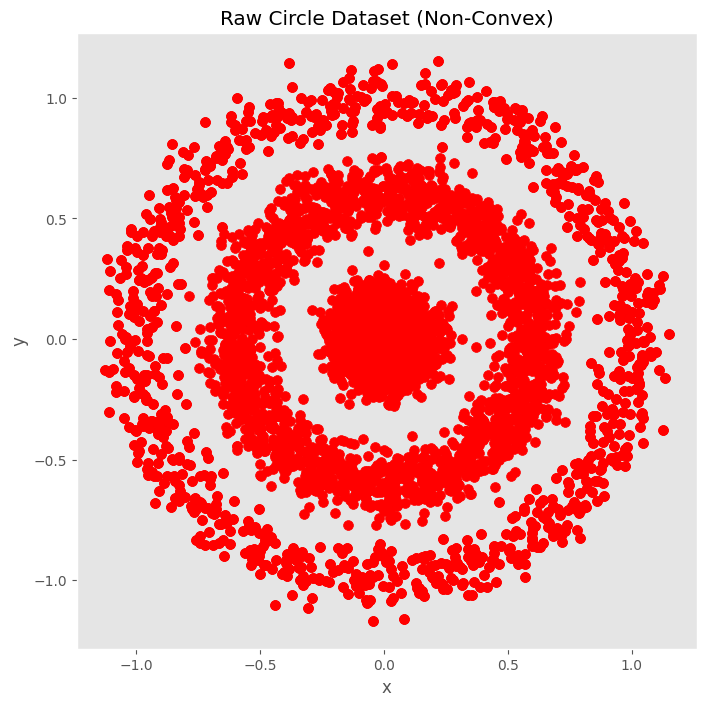

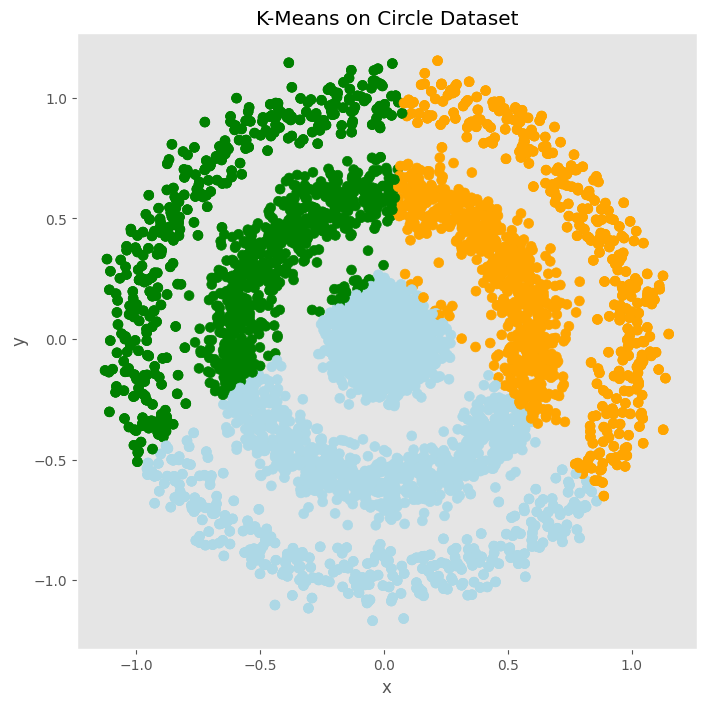

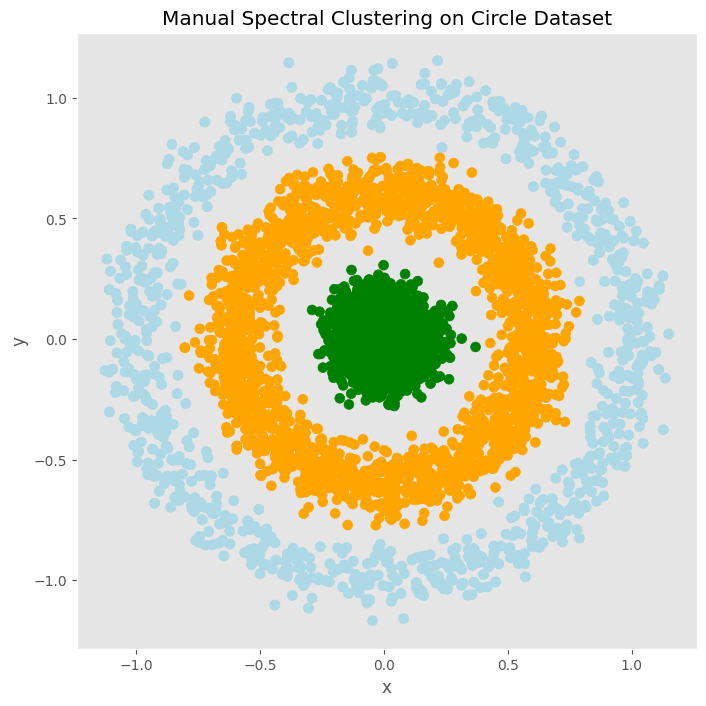

Silhouette Score (Circles) - K-Means: 0.369
Silhouette Score (Circles) - Manual Spectral: 0.094


In [ ]:
# Generate the circle dataset
X_small, y_small = make_circles(n_samples=(1000,2000), random_state=3, noise=0.07, factor=0.1)
X_large, y_large = make_circles(n_samples=(1000,2000), random_state=3, noise=0.07, factor=0.6)
y_large[y_large==1] = 2
df = pd.DataFrame(np.vstack([X_small,X_large]), columns=['x1','x2'])
df['label'] = np.hstack([y_small,y_large])
X_circles = df[['x1','x2']].values
y_true_circles = df['label'].values
circle_dataset = pd.DataFrame(X_circles, columns=['x', 'y'])
circle_dataset['true_labels'] = y_true_circles

# Visualize raw circle data
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], color='red', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Raw Circle Dataset (Non-Convex)')
plt.grid()
plt.show()

# Standardize
scaler_circles = MinMaxScaler().fit(X_circles)
X_circles_scaled = scaler_circles.transform(X_circles)

# Fit K-Means on circles (with 3 clusters)
#The labels (0, 1, 2) for each point are saved
kmeans_circles = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42).fit(X_circles_scaled)
circle_dataset['kmeans_cluster'] = kmeans_circles.labels_


# Visualize K-Means on circles
#Plots the data points on a graph.
#Colors them based on their K-Means cluster
colors_circles = ['lightblue', 'orange', 'green']
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=[colors_circles[label] for label in kmeans_circles.labels_], s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means on Circle Dataset')
plt.grid()
plt.show()

# Manual Spectral Clustering on circles (3 clusters, rbf affinity with gamma=1000 to match the snippet)
spectral_labels_circles = manual_spectral_clustering(X_circles_scaled, n_clusters=3, affinity='rbf', gamma=1000, random_state=42)
circle_dataset['spectral_clusters'] = spectral_labels_circles

# Visualize Manual Spectral Clustering on circles
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=[colors_circles[label] for label in spectral_labels_circles], s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Manual Spectral Clustering on Circle Dataset')
plt.grid()
plt.show()

# Evaluate Clusters for Circles
sil_kmeans_circles = silhouette_score(X_circles_scaled, kmeans_circles.labels_)
sil_spectral_circles = silhouette_score(X_circles_scaled, spectral_labels_circles)
print(f"Silhouette Score (Circles) - K-Means: {sil_kmeans_circles:.3f}")
print(f"Silhouette Score (Circles) - Manual Spectral: {sil_spectral_circles:.3f}")

# Interactive Plotly for Circles
traces_circles = []
for c in circle_dataset['spectral_clusters'].unique():
    temp = circle_dataset[circle_dataset['spectral_clusters'] == c]
    trace = go.Scatter(x=temp['x'], y=temp['y'], mode='markers', 
                       marker=dict(color=colors_circles[c], size=8), 
                       name=f'Cluster {c}')
    traces_circles.append(trace)

layout_circles = go.Layout(title='Interactive Manual Spectral Clustering on Circle Dataset',
                           xaxis=dict(title='x'),
                           yaxis=dict(title='y'),
                           showlegend=True)
fig_circles = go.Figure(data=traces_circles, layout=layout_circles)
plotly.offline.iplot(fig_circles)


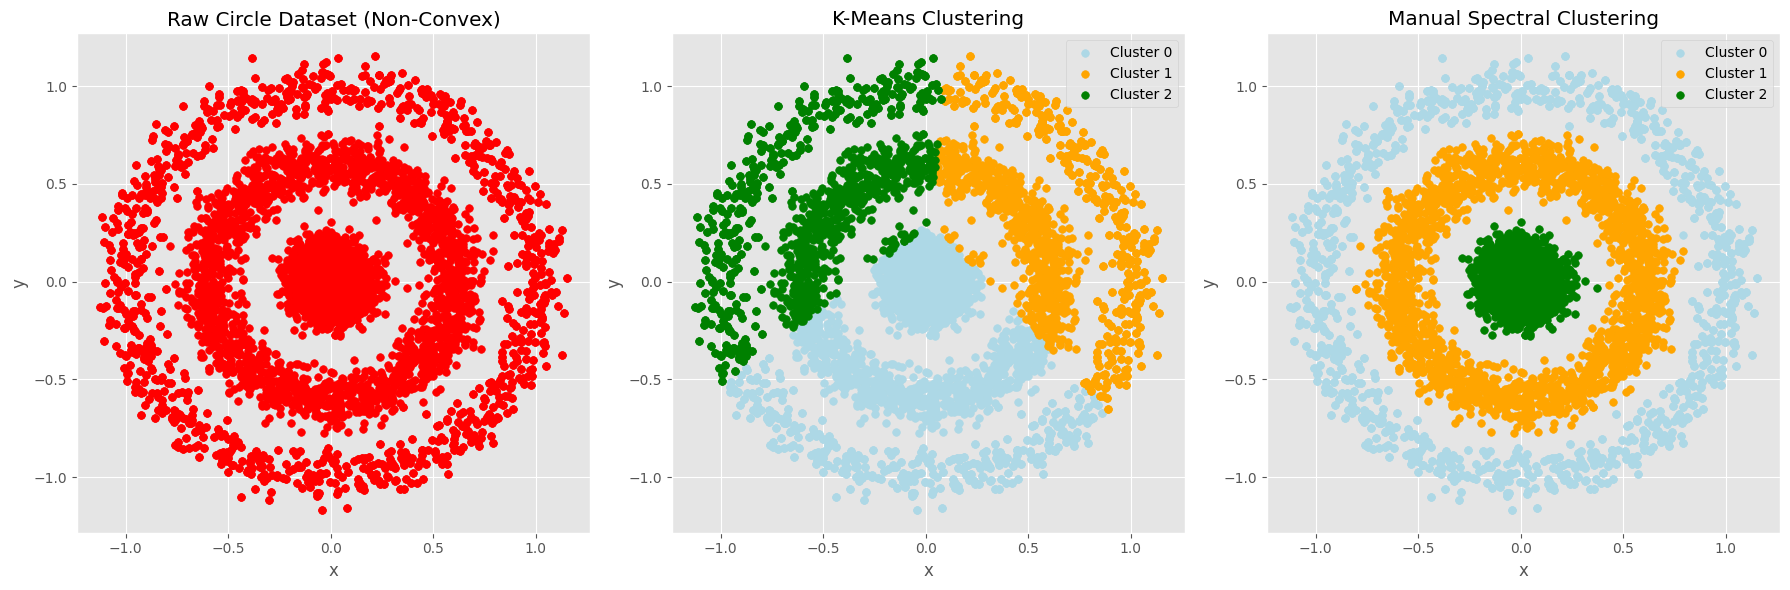

In [21]:
# --- Side-by-side visualization for Circle Dataset ---

# Create a 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors_circles = ['lightblue', 'orange', 'green']

# --- 1. Raw Circle Data ---
axes[0].scatter(X_circles[:, 0], X_circles[:, 1], color='red', s=30)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Raw Circle Dataset (Non-Convex)')
axes[0].grid(True)

# --- 2. K-Means on Circles ---
for c in np.unique(kmeans_circles.labels_):
    temp = circle_dataset[circle_dataset['kmeans_cluster'] == c]
    axes[1].scatter(temp['x'], temp['y'], color=colors_circles[c], label=f'Cluster {c}', s=30)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('K-Means Clustering')
axes[1].legend()
axes[1].grid(True)

# --- 3. Manual Spectral Clustering ---
for c in np.unique(spectral_labels_circles):
    temp = circle_dataset[circle_dataset['spectral_clusters'] == c]
    axes[2].scatter(temp['x'], temp['y'], color=colors_circles[c], label=f'Cluster {c}', s=30)
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title('Manual Spectral Clustering')
axes[2].legend()
axes[2].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [26]:
# --- K-Means Timing & Scoring ---
start_kmeans_circles = time.time()
kmeans_circles = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42).fit(X_circles_scaled)
end_kmeans_circles = time.time()
kmeans_circles_time = end_kmeans_circles - start_kmeans_circles
sil_kmeans_circles = silhouette_score(X_circles_scaled, kmeans_circles.labels_)
circle_dataset['kmeans_cluster'] = kmeans_circles.labels_

# --- Manual Spectral Clustering Timing & Scoring ---
start_spectral_circles = time.time()
spectral_labels_circles = manual_spectral_clustering(
    X_circles_scaled,
    n_clusters=3,
    affinity='rbf',
    gamma=1000,
    random_state=42
)
end_spectral_circles = time.time()
spectral_circles_time = end_spectral_circles - start_spectral_circles
sil_spectral_circles = silhouette_score(X_circles_scaled, spectral_labels_circles)
circle_dataset['spectral_clusters'] = spectral_labels_circles

# --- Display Results ---
print("=== Clustering Performance Summary (Circle Dataset) ===")
print(f"K-Means:")
print(f"  Time Taken       : {kmeans_circles_time:.4f} seconds")
#print(f"  Silhouette Score : {sil_kmeans_circles:.3f}\n")

print(f"Manual Spectral Clustering:")
print(f"  Time Taken       : {spectral_circles_time:.4f} seconds")
#print(f"  Silhouette Score : {sil_spectral_circles:.3f}")


=== Clustering Performance Summary (Circle Dataset) ===
K-Means:
  Time Taken       : 0.1302 seconds
Manual Spectral Clustering:
  Time Taken       : 407.8949 seconds
